In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from math import floor,ceil
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, HTML
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score


import warnings
warnings.simplefilter('ignore', DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#Reading Dataset from  http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
df=pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep=" ",header=None)
headers=["Status of existing checking account","Duration","Credit history",\
         "Purpose","Credit amount","Savings account/bonds","Present employment since",\
         "Installment rate in percentage of disposable income","Personal status and sex",\
         "Other debtors / guarantors","Present residence since","Property","Age",\
        "Other installment plans","Housing","Number of existing credits at this bank",\
        "Job","Number of people being liable to provide maintenance for","Telephone","foreign worker","Risk"]
df.columns=headers
df.to_csv("german_data_credit_cat.csv",index=False) #save as csv file

#for structuring only
Status_of_existing_checking_account={'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM "}
df["Status of existing checking account"]=df["Status of existing checking account"].map(Status_of_existing_checking_account)

Credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
df["Credit history"]=df["Credit history"].map(Credit_history)

Purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
df["Purpose"]=df["Purpose"].map(Purpose)

Saving_account={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= < 1000 DM", "A64" :">= 1000 DM"}
df["Savings account/bonds"]=df["Savings account/bonds"].map(Saving_account)

Present_employment={'A75':">=7 years", 'A74':"4<= <7 years",  'A73':"1<= < 4 years", 'A72':"<1 years",'A71':"unemployed"}
df["Present employment since"]=df["Present employment since"].map(Present_employment)



Personal_status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
df["Personal status and sex"]=df["Personal status and sex"].map(Personal_status_and_sex)


Other_debtors_guarantors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
df["Other debtors / guarantors"]=df["Other debtors / guarantors"].map(Other_debtors_guarantors)

Property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
df["Property"]=df["Property"].map(Property)




Other_installment_plans={'A143':"none", 'A142':"store", 'A141':"bank"}
df["Other installment plans"]=df["Other installment plans"].map(Other_installment_plans)

Housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
df["Housing"]=df["Housing"].map(Housing)




Job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unskilled - resident", 'A171':"unemployed/ unskilled  - non-resident"}
df["Job"]=df["Job"].map(Job)

Telephone={'A192':"yes", 'A191':"none"}
df["Telephone"]=df["Telephone"].map(Telephone)



foreign_worker={'A201':"yes", 'A202':"no"}
df["foreign worker"]=df["foreign worker"].map(foreign_worker)



risk={1:"Good Risk", 2:"Bad Risk"}
df["Risk"]=df["Risk"].map(risk)

In [5]:
df.head()

,Status of existing checking account,Duration,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Risk
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,4,male:single,none,4,real estate,67,none,own,2,skilled employee / official,1,yes,yes,Good Risk
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,2,female:divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad Risk
2,no checking account,12,critical account,education,2096,<100 DM,4<= <7 years,2,male:single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good Risk
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,2,male:single,guarantor,4,savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,Good Risk
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,3,male:single,none,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad Risk


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status of existing checking account                       1000 non-null   object
 1   Duration                                                  1000 non-null   int64 
 2   Credit history                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Savings account/bonds                                     1000 non-null   object
 6   Present employment since                                  1000 non-null   object
 7   Installment rate in percentage of disposable income       1000 non-null   int64 
 8   Personal status and sex      

In [7]:
df.describe()

,Duration,Credit amount,Installment rate in percentage of disposable income,Present residence since,Age,Number of existing credits at this bank,Number of people being liable to provide maintenance for
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [8]:
df.isnull().sum()

Status of existing checking account                         0
Duration                                                    0
Credit history                                              0
Purpose                                                     0
Credit amount                                               0
Savings account/bonds                                       0
Present employment since                                    0
Installment rate in percentage of disposable income         0
Personal status and sex                                     0
Other debtors / guarantors                                  0
Present residence since                                     0
Property                                                    0
Age                                                         0
Other installment plans                                     0
Housing                                                     0
Number of existing credits at this bank                     0
Job     

In [9]:
df.drop('Status of existing checking account', axis=1,inplace = True)
df.drop('Number of people being liable to provide maintenance for', axis=1,inplace = True)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Duration                                             1000 non-null   int64 
 1   Credit history                                       1000 non-null   object
 2   Purpose                                              1000 non-null   object
 3   Credit amount                                        1000 non-null   int64 
 4   Savings account/bonds                                1000 non-null   object
 5   Present employment since                             1000 non-null   object
 6   Installment rate in percentage of disposable income  1000 non-null   int64 
 7   Personal status and sex                              1000 non-null   object
 8   Other debtors / guarantors                           1000 non-null   object
 9 

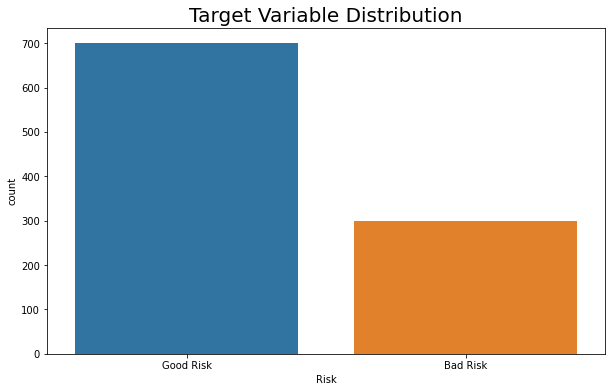

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Risk")
plt.title("Target Variable Distribution", fontsize=20)
plt.show()

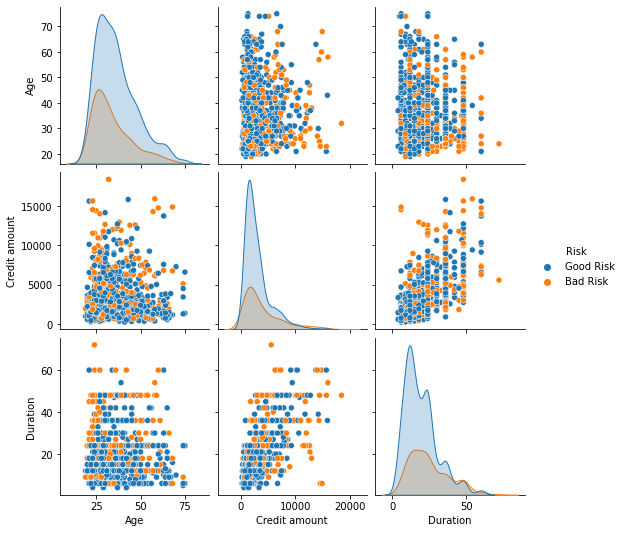

In [12]:
num_cat_risk = ['Age', 'Credit amount', 'Duration', 'Risk']
sns.pairplot(df[num_cat_risk], hue="Risk")
plt.show()

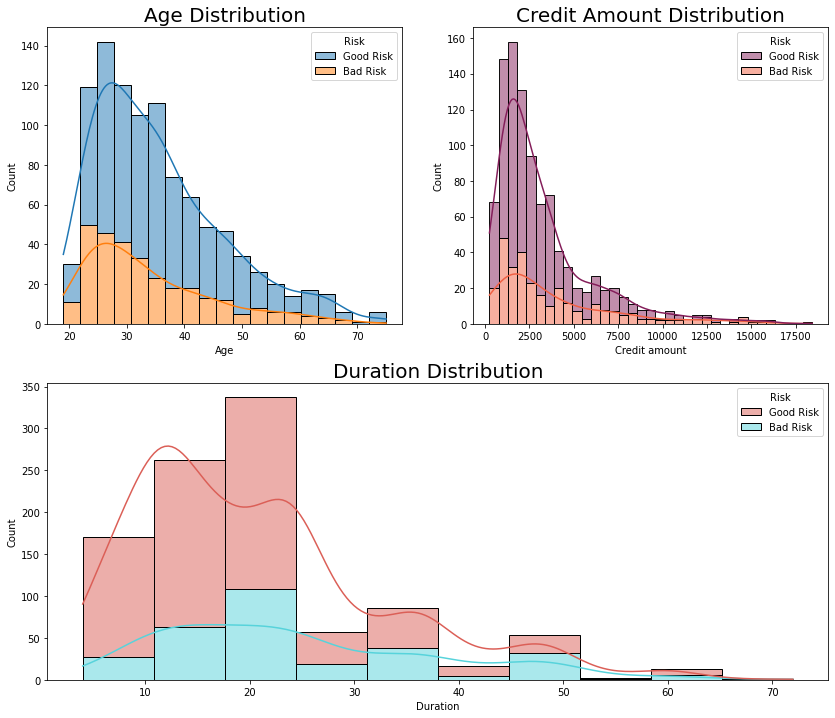

In [13]:
plt.figure(figsize=(14, 12))

plt.subplot(221)
ax1 = sns.histplot(data=df, x='Age', hue='Risk', multiple='stack', palette='tab10', kde=True)
ax1.set_title("Age Distribution", fontsize=20)

plt.subplot(222)
ax2 = sns.histplot(data=df, x='Credit amount', hue='Risk', multiple='stack', palette='rocket', kde=True)
ax2.set_title("Credit Amount Distribution", fontsize=20)

plt.subplot(212)
ax3 = sns.histplot(data=df, x='Duration', hue='Risk', multiple='stack', palette='hls', kde=True, bins=10)
ax3.set_title("Duration Distribution", fontsize=20)

plt.show()

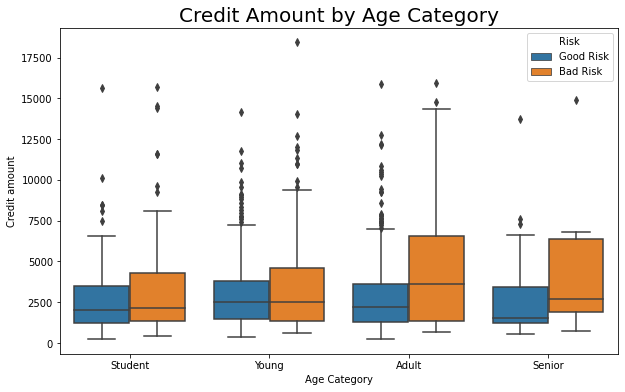

In [14]:
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age Category"] = pd.cut(df.Age, interval, labels=cats)

plt.figure(figsize=(10, 6))
plt.title("Credit Amount by Age Category", fontsize=20)
sns.boxplot(data=df, x='Age Category', y='Credit amount', hue='Risk')
plt.show()

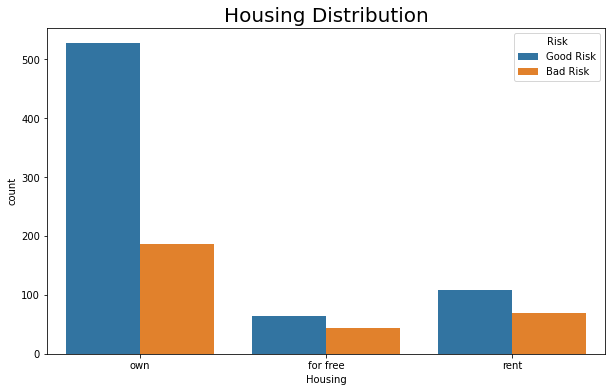

In [15]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Housing', hue='Risk')
plt.title("Housing Distribution", fontsize=20)
plt.show()

Feature Selection

In [16]:
attr_significant=["Credit history","Purpose",\
"Savings account/bonds","Present employment since",\
"Personal status and sex","Property","Other installment plans","Housing","foreign worker",\
"Credit amount","Age","Duration"]
target_variable=["Risk"]
df=df[attr_significant+target_variable]

In [17]:
risk={"Good Risk":1, "Bad Risk":0}
df["Risk"]=df["Risk"].map(risk)

In [18]:
df.head()

,Credit history,Purpose,Savings account/bonds,Present employment since,Personal status and sex,Property,Other installment plans,Housing,foreign worker,Credit amount,Age,Duration,Risk
0,critical account,radio/television,no savings account,>=7 years,male:single,real estate,none,own,yes,1169,67,6,1
1,existing credits paid back duly till now,radio/television,<100 DM,1<= < 4 years,female:divorced/separated/married,real estate,none,own,yes,5951,22,48,0
2,critical account,education,<100 DM,4<= <7 years,male:single,real estate,none,own,yes,2096,49,12,1
3,existing credits paid back duly till now,furniture/equipment,<100 DM,4<= <7 years,male:single,savings agreement/life insurance,none,for free,yes,7882,45,42,1
4,delay in paying off,car (new),<100 DM,1<= < 4 years,male:single,unknown / no property,none,for free,yes,4870,53,24,0


In [20]:
# Spliting dataset into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,random_state=0)

In [25]:
# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(700, 12)
(700,)
(300, 12)
(300,)


Logistic Regression

In [1]:
!pip install aif360

     |████████████████████████████████| 175 kB 26.3 MB/s 
     |████████████████████████████████| 564 kB 68.2 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=3543a2ee224c50e7841516f28ef549a18d255774210e23c0205cc7d8a6ab20a3
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc


--2022-05-12 06:21:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data.1’

german.data.1       100%[===================>]  77.92K  --.-KB/s    in 0.06s   

2022-05-12 06:21:34 (1.34 MB/s) - ‘german.data.1’ saved [79793/79793]

--2022-05-12 06:21:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102000 (100K) [application/x-httpd-php]
Saving to: ‘german.data-numeric.1’

german.data-numeric 100%[===================>]  

In [ ]:
# Load all necessary packages
import sys
import numpy as np
from aif360.datasets import GermanDataset
from aif360.metrics import DatasetMetric, utils
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.neighbors import NearestNeighbors
from aif360.algorithms.preprocessing import Reweighing
from IPython.display import Markdown, display

In [ ]:
#loading the dataset
# this dataset also contains protected attribute for "sex" which we do not
# consider in this evaluation
dataset_orig = GermanDataset(
    protected_attribute_names=['age'],         
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)
#dividing the dataset into train and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

In [ ]:
import numpy as np
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
import pdb
from sklearn.preprocessing import StandardScaler  #MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import *

np.random.seed(0)

In [ ]:
#STEP 2: We define where's the bias in the features of our dataset.

# train, test = dataset_orig.split([0.7], shuffle=True)
print("training data size", dataset_orig_train.features.shape)
print("dataset feature names", dataset_orig_train.feature_names)

#Normalize the dataset, both train and test. This should always be done in any machine learning pipeline!
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels

X_test = scale_orig.transform(dataset_orig_test.features) 
y_test = dataset_orig_test.labels.ravel()

training data size (700, 57)
dataset feature names ['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174

In [ ]:
#We use a simple Logistic Regression to parametrise our classifier. 
#You can try different classifiers and hyperparameters, checking how the metrics will change.

learner = LogisticRegression(solver='liblinear', random_state=1)  
learner.fit(X_train,y_train.ravel())
predictions = learner.predict(X_test)

test_pred = dataset_orig_test.copy()
test_pred.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))
metric = ClassificationMetric(dataset_orig_test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
metric_arrs['disp_imp']=(metric.disparate_impact())
print(metric_arrs)

Accuracy 0.7533333333333333
{'stat_par_diff': -0.19823232323232332, 'eq_opp_diff': -0.3005405405405406, 'avg_odds_diff': -0.12955680651883184, 'bal_acc': 0.6523809523809524, 'disp_imp': 0.7631975867269984}


In [ ]:
import numpy as np
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=False)

i=0
c = [1.0, 100000., 0.001, 0.000001,1000]
max_iter = [ 500,1000,2500,3500,5000 ]
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# enumerate splits
x_train_np = np.array(X_train)
y_train_np = np.array(y_train)
for train_ix, test_ix in kf.split(X_train):
    x_tr, x_test = x_train_np[train_ix], x_train_np[test_ix]
    y_tr, y_test = y_train_np[train_ix], y_train_np[test_ix]
    model = LogisticRegression(solver='liblinear', random_state=1,max_iter = max_iter[i], C = c[i])
    model.fit(x_tr, y_tr.ravel())
    preds = model.predict(x_test)
    test_pred = dataset_orig_train.copy().subset(test_ix)
    test_pred.labels = preds
    print("Accuracy", sum(preds==y_test)/len(y_test),"c-value:",c[i], "max_iter :" ,max_iter[i] )
    scores = cross_val_score(model, x_tr, y_tr.ravel(), scoring='accuracy', cv=kf, n_jobs=-1)
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    # print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    metric = ClassificationMetric(dataset_orig_train.subset(test_ix), test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    metric_arrs = {}
    metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
    metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
    metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
    metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
    metric_arrs['disp_imp']=(metric.disparate_impact())
    print(metric_arrs)
    i+=1

Accuracy [0.25 0.75 0.75 0.75 0.25 0.75 0.75 0.75 0.75 0.25 0.25 0.25 0.75 0.75
 0.25 0.75 0.75 0.75 0.25 0.75 0.25 0.25 0.25 0.75 0.75 0.25 0.75 0.75
 0.75 0.25 0.75 0.75 0.75 0.75 0.75 0.25 0.75 0.75 0.75 0.75 0.25 0.25
 0.75 0.75 0.75 0.25 0.25 0.25 0.75 0.75 0.75 0.25 0.75 0.75 0.25 0.75
 0.25 0.75 0.75 0.75 0.25 0.75 0.25 0.75 0.75 0.75 0.75 0.25 0.25 0.75
 0.75 0.75 0.25 0.25 0.25 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.25
 0.75 0.75 0.75 0.75 0.75 0.25 0.75 0.75 0.25 0.75 0.75 0.25 0.75 0.75
 0.25 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.25 0.25 0.75 0.75 0.25
 0.25 0.75 0.75 0.75 0.75 0.75 0.75 0.25 0.75 0.75 0.75 0.25 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.25 0.25 0.75 0.75 0.75 0.75 0.75 0.25 0.25] c-value: 1.0 max_iter : 500
Mean Accuracy: 0.705 (0.054)
{'stat_par_diff': -0.1428571428571429, 'eq_opp_diff': -0.056451612903225756, 'avg_odds_diff': -0.05386683209263854, 'bal_acc': 0.7142857142857143, 'disp_imp': 0.7999999999999999}
Accuracy [0.32857143 0.32857143 0.67142857 0

In [ ]:
# learner = LogisticRegression(solver='liblinear', random_state=1, max_iter = 5000, C = 10)  
#We use a simple Logistic Regression to parametrise our classifier. 
#You can try different classifiers and hyperparameters, checking how the metrics will change.

learner = LogisticRegression(solver='liblinear', random_state=1, max_iter = 5000, C = 10)  
learner.fit(X_train,y_train.ravel())
predictions = learner.predict(X_test)

test_pred = dataset_orig_test.copy()
test_pred.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))
scores = cross_val_score(learner, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
metric = ClassificationMetric(dataset_orig_test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
metric_arrs = {}
metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
metric_arrs['disp_imp']=(metric.disparate_impact())
print(metric_arrs)

Accuracy [0.65714286 0.34285714 0.65714286 0.65714286 0.65714286 0.34285714
 0.65714286 0.65714286 0.34285714 0.65714286 0.65714286 0.65714286
 0.65714286 0.65714286 0.34285714 0.65714286 0.34285714 0.65714286
 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286
 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286
 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286
 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286 0.65714286
 0.65714286 0.65714286 0.34285714 0.65714286 0.65714286 0.65714286
 0.65714286 0.34285714 0.34285714 0.65714286 0.65714286 0.65714286
 0.65714286 0.34285714 0.65714286 0.65714286 0.65714286 0.65714286
 0.34285714 0.65714286 0.65714286 0.65714286 0.34285714 0.65714286
 0.65714286 0.65714286 0.65714286 0.65714286 0.34285714 0.34285714
 0.65714286 0.65714286 0.34285714 0.65714286 0.65714286 0.34285714
 0.65714286 0.34285714 0.65714286 0.34285714 0.65714286 0.65714286
 0.65714286 0.65714286 0.65714286 0.65714286 0.657142

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=None, shuffle=False)

i=0
c = [1.0, 100000., 0.001, 0.000001,1000]
max_iter = [ 500,1000,2500,3500,5000 ]
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# enumerate splits
x_train_np = np.array(X_train)
y_train_np = np.array(y_train)
for train_ix, test_ix in kf.split(X_train):
    x_tr, x_test = x_train_np[train_ix], x_train_np[test_ix]
    y_tr, y_test = y_train_np[train_ix], y_train_np[test_ix]
    RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
    dataset_orig_train = RW.fit_transform(dataset_orig_train)
    model = LogisticRegression(solver='liblinear', random_state=1,max_iter = max_iter[i], C = c[i])
    model.fit(x_tr, y_tr.ravel())
    preds = model.predict(x_test)
    test_pred = dataset_orig_train.copy().subset(test_ix)
    test_pred.labels = preds
#     results = a accuracy_score(y_true, y_pred, normalize=False)
    print("Accuracy", sum(preds==y_test)/len(y_test),"c-value:",c[i], "max_iter :" ,max_iter[i] )
    scores = cross_val_score(model, x_tr, y_tr.ravel(), scoring='accuracy', cv=kf, n_jobs=-1)
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    metric = ClassificationMetric(dataset_orig_train.subset(test_ix), test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    metric_arrs = {}
    metric_arrs['stat_par_diff']=(metric.statistical_parity_difference())
    metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
    metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
    metric_arrs['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
    metric_arrs['disp_imp']=(metric.disparate_impact())
    print(metric_arrs)
    i+=1

Accuracy [0.25 0.75 0.75 0.75 0.25 0.75 0.75 0.75 0.75 0.25 0.25 0.25 0.75 0.75
 0.25 0.75 0.75 0.75 0.25 0.75 0.25 0.25 0.25 0.75 0.75 0.25 0.75 0.75
 0.75 0.25 0.75 0.75 0.75 0.75 0.75 0.25 0.75 0.75 0.75 0.75 0.25 0.25
 0.75 0.75 0.75 0.25 0.25 0.25 0.75 0.75 0.75 0.25 0.75 0.75 0.25 0.75
 0.25 0.75 0.75 0.75 0.25 0.75 0.25 0.75 0.75 0.75 0.75 0.25 0.25 0.75
 0.75 0.75 0.25 0.25 0.25 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.25
 0.75 0.75 0.75 0.75 0.75 0.25 0.75 0.75 0.25 0.75 0.75 0.25 0.75 0.75
 0.25 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.25 0.25 0.75 0.75 0.25
 0.25 0.75 0.75 0.75 0.75 0.75 0.75 0.25 0.75 0.75 0.75 0.25 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.25 0.25 0.75 0.75 0.75 0.75 0.75 0.25 0.25] c-value: 1.0 max_iter : 500
Mean Accuracy: 0.705 (0.054)
{'stat_par_diff': -0.07435362988236527, 'eq_opp_diff': -0.05645161290322598, 'avg_odds_diff': -0.05386683209263862, 'bal_acc': 0.711357503446922, 'disp_imp': 0.8944210713210492}
Accuracy [0.32857143 0.32857143 0.67142857 0.